# Voluntary Confinement

__authors__="Dominique Baril-Tremblay, Chantal Marlats, and Lucie Menager"\
__copyright__ = "Copyright 2020, Voluntary Confinement"\
__date__="November 4, 2020"\
__email__="doumbaril@gmail.com"\

## Simulations

We illustrate the impact of self-isolation behaviors on the dynamics of the epidemic, and to highlight the policy lessons that can be drawn from our findings. To do so, we simulate the dynamics of the epidemic in the interior equilibrium described in Proposition 4, and compare it with the dynamics of the standard SIR model (referred to as the SIR model in the rest of the section), i.e., the model described by equations (1) and (2)
with $\bar{k}_{S(t)}$ = $\bar{k}_{I(t)}$ = 1 . 

We chose the behavioral parameters $c_I$ , $c_H$ and $c_D$ arbitrarily in such
a way that the interior equilibrium exists, and we calibrate the epidemiological parameters $\beta$,
$\gamma$, $\mu$ and $\nu$ to the COVID-19 pandemic.

### Calibration

Initial fraction of the population that is infected: $i_0 = 0.1\%$. 
Individual discount time at rate: $r = 0.014\%$, in line with in Fenichel et al. (2011). 
Time of announcement: $\tau = 30$.
Vaccine arrive at $T = 350$. 
We set the costs arbitrarily to $c_H = 0.0009$, $c_I = 0.09$ and $c_D = 9$.


The proportion of asymptomatic individuals $\mu = 0.2885$ in line with Pollan et al. (2020). We use the estimates of Remuzzi and Remuzzi (2020)'s, i.e., a basic reproduction number of $R_0 = 2.76$ and a recovery rate $\gamma = 1/15$. 

In [12]:
import numpy as np
%matplotlib inline
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import math

matplotlib.rcParams['text.usetex'] = True
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


## NOTES ##
# The variables indexed m are the variables of the modified SIR epidemiological model. 
# pol: Indicates at which period the epidemic was announced to the population.


# Total population, N.
N, Nm = 1, 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, Im0, Rm0 = 0.1/100, 0, 0.1/100, 0
# Everyone else, S0, is susceptible to infection initially.
S0, Sm0 = 1 - I0 - R0 , 1 -Im0 - Rm0


def BMM(pol,cp,bp,gp,ep,vp,ap):

    #Type distribution
    mu=0.2885*ap #proportion of asymptomatic

    #Initial beliefs
    Pm0=1-mu 
    
    #epidemiological parameters
    #Remuzzi A, Remuzzi G. COVID-19 and Italy: what next? Lancet 2020;2:10–3.
    brn=2.76*ep       #Basic Reproduction Number
    gamma=1/(15)*gp          #Recovery Rate
    dr=0.038          #Death Rate
    
    vs=(dr*gamma)/(1-dr)*vp
    v=((1-mu)*(dr*gamma)/(1-dr))*vp          
    betamu=(brn*(gamma))*ap*bp     
    
    #behavioral parameters 
    r=0.00014
    CH=0.0009*cp    #Cost of staying at home
    CI=0.09         #Cost of infection
    CD=9.00        #Cost of death
    VI=-(CI+CH+(vs*(CD/r)))/(gamma + r +vs)
    TH=350

    # A grid of time points (in days)
    t = np.linspace(0, TH, TH)
    
    #The SIR model differential equations.
    def deriv(y, t, betamu, gamma, v):
        S, I, R = y
        dSdt = -(betamu*I*S)
        dIdt = (betamu*I*S) - (gamma*I) - (v*I)
        dRdt = (gamma*I) + (v*I)
        return dSdt, dIdt, dRdt 
    
    # The modified SIR model differential equations.
    def derivm(y, t, betamu, gamma, v, CH, VI, r, TH, kt):
        Sm, Im, Pm = y
        if (kt is 0):
            kt=CH/(Pm*betamu*Im*(-VI-((CH/r))*(1-math.exp(-r*(TH-t)))))
            if(kt>1):
                kt=1
        dSmdt = -(betamu*Im*Sm*kt**2)
        dImdt = (betamu*Im*Sm*kt**2) - (gamma*Im) - (v*Im)
        dPmdt = -(Pm*(1-Pm)*betamu*Im*kt**2)
        return dSmdt, dImdt, dPmdt
    
    # Initial conditions vectors (ICV)
    y0 = S0, I0, R0     
    
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(betamu, gamma, v))
    S, I, R = ret.T
    
    #Effective Reproduction Number - SIR
    ernSIR=np.array(S*((betamu)/(gamma+v)))
    
    # Initial conditions vectors of the modified SIR over 0 to pol.
    ym0 = Sm0, Im0, Pm0     
    
    # Integrate the SIR modified equations over 0 to pol.
    retm1 = odeint(derivm, ym0, t[0:pol], args=(betamu, gamma, v, CH, VI, r , TH, 1))
    Sm1, Im1, Pm1 = retm1.T
    
    # Initial conditions vectors modified SIR starting at t=pol
    ym1 = Sm1[pol-1], Im1[pol-1], Pm1[pol-1]     
    
    # Integrate SIR modified over pol to TH
    retm2 = odeint(derivm, ym1, t[pol:TH], args=(betamu,gamma, v, CH, VI, r, TH, 0))
    Sm2, Im2, Pm2 = retm2.T
    
    # Merging both integrated arrays for complete model
    Sm=np.append(Sm1,Sm2)
    Im=np.append(Im1,Im2)
    Pm=np.append(Pm1,Pm2)
    
    # Recovered individuals in the modified version of the model
    Rm = 1 - Im - Sm
   
     # upperbound K(t) + Effective Reproduction Number - modified SIR
    ktm=[]
    ernSIRm=[]
    for i in range(0,TH):
        if i >= pol:
            ktm.append(CH/(Pm[i]*betamu*Im[i]*(-VI-(((CH)/r))*(1-np.exp(-r*(TH-i))))))
        else:
            ktm.append(1)
        if ktm[i] < 0: ktm[i]=0
        if ktm[i] > 1: ktm[i]=1          
        ernSIRm.append(Sm[i]*((betamu*ktm[i]**2)/((gamma)+(v))))
        
    deathSIR=np.array(v*I)
    deathSIRm=np.array(v*Im)
    
    
    
    return deathSIR, deathSIRm, S, I, R, Sm, Im, Rm, Pm, ktm, ernSIR, ernSIRm
   # main function with pol as parameter  


##### Defining colors for the following graphics

In [13]:
##Color definition##

#Rainbow#
rain1, rain2, rain3, rain4, rain5, rain6='#862d86','#0000ff','#009900','#ffcc00','#ff6600','#ff0000'
#From darker to light
#Blues#
blu1, blu2, blu3, blu4, blu5, blu6, blu7='#000033','#000080','#0000b3','#0000ff','#4d4dff','#8080ff','#b3b3ff'
#Reds#
red1, red2, red3, red4, red5, red6, red7='#330000','#660000','#990000','#cc0000','#ff0000','#ff3333','#ff6666'
#Greens#
gre1, gre2, gre3, gre4, gre5, gre6, gre7='#0d260d','#194d19','#267326','#339933','#40bf40','#66cc66','#8cd98c'
#Purples#
pur1, pur2, pur3, pur4, pur5, pur6, pur7='#260d26','#4d194d','#732673','#993399','#bf40bf','#cc66cc','#d98cd9'
#Oranges#
ora1, ora2, ora3, ora4, ora5, ora6, ora7='#4d1f00','#993d00','#cc5200','#ff6600','#ff8533','#ffa366','#ffc299'
#grey#
grey1, grey2, grey3, grey4, grey5, grey6, grey7='#000000','#404040','#666666','#808080', '#a6a6a6','#bfbfbf', '#e6e6e6'


#### This function generates arrays of values.

In [14]:
#Array generation
def toplot(values):
    x=[]
    for value in range(len(values)):
        x.append(np.array(values[value]))
    return x

### BMM vs SIR & BMM time of annoucement

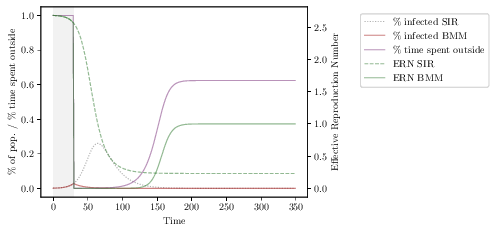

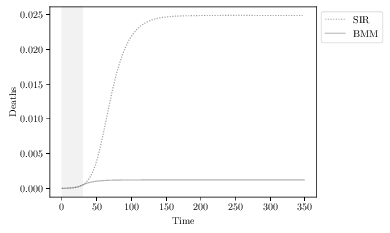

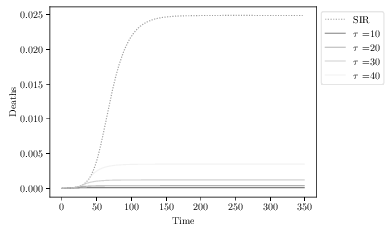

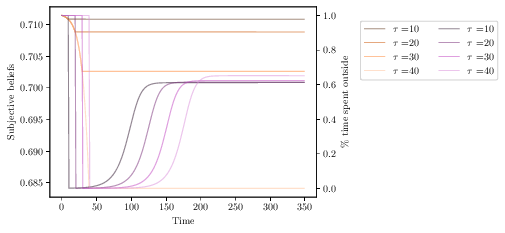

In [15]:
#BMM vs SIR
#BMM time of announcement

#Susceptible#
sm00, sm10, sm20, sm30, sm40, sm50 = toplot([BMM(30,1,1,1,1,1,1)[2],
                                      BMM(10,1,1,1,1,1,1)[5],
                                      BMM(20,1,1,1,1,1,1)[5],
                                      BMM(30,1,1,1,1,1,1)[5],
                                      BMM(40,1,1,1,1,1,1)[5],      
                                      BMM(50,1,1,1,1,1,1)[5]])
#Infected#
im00, im10, im20, im30, im40, im50 = toplot([BMM(30,1,1,1,1,1,1)[3],
                                      BMM(10,1,1,1,1,1,1)[6],
                                      BMM(20,1,1,1,1,1,1)[6],
                                      BMM(30,1,1,1,1,1,1)[6],
                                      BMM(40,1,1,1,1,1,1)[6],  
                                      BMM(50,1,1,1,1,1,1)[6]])
#Recovered#
rm00, rm10, rm20, rm30, rm40, rm50 = toplot([BMM(30,1,1,1,1,1,1)[4],
                                      BMM(10,1,1,1,1,1,1)[7],
                                      BMM(20,1,1,1,1,1,1)[7],
                                      BMM(30,1,1,1,1,1,1)[7],
                                      BMM(40,1,1,1,1,1,1)[7],
                                      BMM(50,1,1,1,1,1,1)[7]])
#Subjective beliefs (Pt)#
pm10, pm20, pm30, pm40, pm50 = toplot([BMM(10,1,1,1,1,1,1)[8],
                                      BMM(20,1,1,1,1,1,1)[8],
                                      BMM(30,1,1,1,1,1,1)[8],
                                      BMM(40,1,1,1,1,1,1)[8],
                                      BMM(50,1,1,1,1,1,1)[8]])
#Time spent outside (Kt)#
km10, km20, km30, km40, km50 = toplot([BMM(10,1,1,1,1,1,1)[9],
                                      BMM(20,1,1,1,1,1,1)[9],
                                      BMM(30,1,1,1,1,1,1)[9],
                                      BMM(40,1,1,1,1,1,1)[9],
                                      BMM(50,1,1,1,1,1,1)[9]])
#Effective Reproduction Number#
ern00, ern10, ern20, ern30, ern40, ern50 = toplot([BMM(30,1,1,1,1,1,1)[10],
                                      BMM(10,1,1,1,1,1,1)[11],
                                      BMM(20,1,1,1,1,1,1)[11],
                                      BMM(30,1,1,1,1,1,1)[11],
                                      BMM(40,1,1,1,1,1,1)[11],
                                      BMM(50,1,1,1,1,1,1)[11]])
#Deaths#
d00=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[0]))
d10=np.cumsum(np.array(BMM(10,1,1,1,1,1,1)[1]))
d20=np.cumsum(np.array(BMM(20,1,1,1,1,1,1)[1]))
d30=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[1]))
d40=np.cumsum(np.array(BMM(40,1,1,1,1,1,1)[1]))
d50=np.cumsum(np.array(BMM(50,1,1,1,1,1,1)[1]))

## BMM vs SIR - i, kt, ern
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
Inf0=ax.plot(im00, grey3, linestyle=':', alpha=0.5, lw=1, label=r'\% infected SIR')
Inf1=ax.plot(im30, red3,alpha=0.5, lw=1, label=r'\% infected BMM')
K1=ax.plot(km30, pur3,alpha=0.5, lw=1, label=r'\% time spent outside')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('$\%$ of pop. / $\%$ time spent outside')
legend = ax.legend(title='Volontary confinement ',loc='center right', ncol=1,bbox_to_anchor=(1.65, 0.5))
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
ax2.set_ylabel('Effective Reproduction Number')
ERN0=ax2.plot(ern00, gre3, linestyle='dashed', alpha=0.5, lw=1, label=r'ERN SIR')
ERN1=ax2.plot(ern30, gre3,alpha=0.5, lw=1, label=r'ERN BMM')
COMB=Inf0+Inf1+K1+ERN0+ERN1 
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=1,bbox_to_anchor=(1.70, 0.77))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_Figure1.pdf',bbox_inches='tight')

## BMM vs SIR - Deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(d00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(d30, grey3,alpha=0.5, lw=1, label='BMM')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_Figure2.pdf',bbox_inches='tight')

## BMM - Time of announcement - Deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(d00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(d10, grey1,alpha=0.5, lw=1, label=r'$\tau$ =10')
ax.plot(d20, grey3,alpha=0.5, lw=1, label=r'$\tau$ =20')
ax.plot(d30, grey5,alpha=0.5, lw=1, label=r'$\tau$ =30')
ax.plot(d40, grey7,alpha=0.5, lw=1, label=r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig("BMM_Covid19_Figure3.pdf",bbox_inches='tight')

## BMM - Time of annoucement - Pt, Kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM01=ax.plot(pm10, ora1,alpha=0.5, lw=1, label=r'$\tau$ =10')
PM02=ax.plot(pm20, ora3,alpha=0.5, lw=1, label=r'$\tau$ =20')
PM03=ax.plot(pm30, ora5,alpha=0.5, lw=1, label=r'$\tau$ =30')
PM04=ax.plot(pm40, ora7,alpha=0.5, lw=1, label=r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K01=ax2.plot(km10, pur1,alpha=0.5, lw=1, label=r'$\tau$ =10')
K02=ax2.plot(km20, pur3,alpha=0.5, lw=1, label=r'$\tau$ =20')
K03=ax2.plot(km30, pur5,alpha=0.5, lw=1, label=r'$\tau$ =30')
K04=ax2.plot(km40, pur7,alpha=0.5, lw=1, label=r'$\tau$ =40')
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM01+PM02+PM03+PM04+K01+K02+K03+K04
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(1.70, 0.77))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig("BMM_Covid19_Figure4.pdf",bbox_inches='tight')



### Simulation on $\beta$

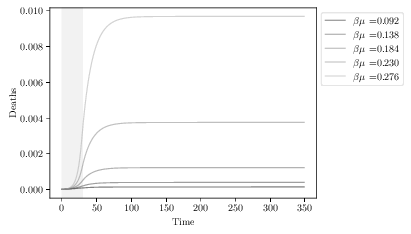

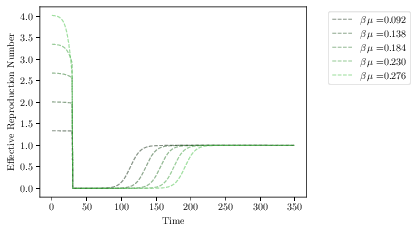

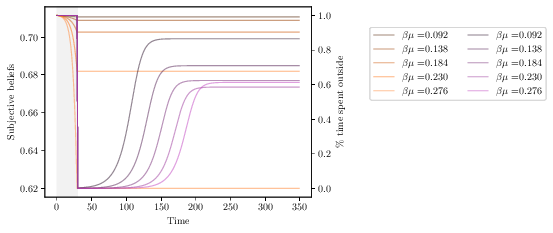

In [16]:
#Beta

#Susceptible#
smb0, smb1, smb2, smb3, smb4, smb5 = toplot([BMM(30,1,1,1,1,1,1)[2],
                                      BMM(30,1,1,1,0.5,1,1)[5],
                                      BMM(30,1,1,1,0.75,1,1)[5],
                                      BMM(30,1,1,1,1,1,1)[5],
                                      BMM(30,1,1,1,1.25,1,1)[5],
                                      BMM(30,1,1,1,1.5,1,1)[5]])
#Infected#
imb0, imb1, imb2, imb3, imb4, imb5 = toplot([BMM(30,1,1,1,1,1,1)[3],
                                      BMM(30,1,1,1,0.5,1,1)[6],
                                      BMM(30,1,1,1,0.75,1,1)[6],
                                      BMM(30,1,1,1,1,1,1)[6],
                                      BMM(30,1,1,1,1.25,1,1)[6],
                                      BMM(30,1,1,1,1.5,1,1)[6]])
#Pt#
pmb1, pmb2, pmb3, pmb4, pmb5 = toplot([BMM(30,1,1,1,0.5,1,1)[8],
                                      BMM(30,1,1,1,0.75,1,1)[8],
                                      BMM(30,1,1,1,1,1,1)[8],
                                      BMM(30,1,1,1,1.25,1,1)[8],
                                      BMM(30,1,1,1,1.5,1,1)[8]])
#Kt#
kmb1, kmb2, kmb3, kmb4, kmb5= toplot([BMM(30,1,1,1,0.5,1,1)[9],
                                      BMM(30,1,1,1,0.75,1,1)[9],
                                      BMM(30,1,1,1,1,1,1)[9],
                                      BMM(30,1,1,1,1.25,1,1)[9],
                                      BMM(30,1,1,1,1.5,1,1)[9]])
#Kt#
ernb0, ernb1, ernb2, ernb3, ernb4, ernb5 = toplot([BMM(30,1,1,1,1,1,1)[10],
                                      BMM(30,1,1,1,0.5,1,1)[11],
                                      BMM(30,1,1,1,0.75,1,1)[11],
                                      BMM(30,1,1,1,1,1,1)[11],
                                      BMM(30,1,1,1,1.25,1,1)[11],
                                      BMM(30,1,1,1,1.5,1,1)[11]])
#Deaths#
db0=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[0]))
db1=np.cumsum(np.array(BMM(30,1,1,1,0.5,1,1)[1]))
db2=np.cumsum(np.array(BMM(30,1,1,1,0.75,1,1)[1]))
db3=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[1]))
db4=np.cumsum(np.array(BMM(30,1,1,1,1.25,1,1)[1]))
db5=np.cumsum(np.array(BMM(30,1,1,1,1.5,1,1)[1]))

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(db1, grey1,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.092')
ax.plot(db2, grey2,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.138')
ax.plot(db3, grey3,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.184')
ax.plot(db4, grey4,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.230')
ax.plot(db5, grey5,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.276')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_PolicyB_Deaths.pdf',bbox_inches='tight')

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ernb1, gre1,linestyle='dashed',alpha=0.5, lw=1, label=r'$\beta \mu$ =0.092')
ax.plot(ernb2, gre2,linestyle='dashed',alpha=0.5, lw=1, label=r'$\beta \mu$ =0.138')
ax.plot(ernb3, gre3,linestyle='dashed',alpha=0.5, lw=1, label=r'$\beta \mu$ =0.184')
ax.plot(ernb4, gre4,linestyle='dashed',alpha=0.5, lw=1, label=r'$\beta \mu$ =0.230')
ax.plot(ernb5, gre5,linestyle='dashed',alpha=0.5, lw=1, label=r'$\beta \mu$ =0.276')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.41, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_PolicyB_ERN.pdf',bbox_inches='tight')

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM001=ax.plot(pmb1, ora1,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.092')
PM002=ax.plot(pmb2, ora2,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.138')
PM003=ax.plot(pmb3, ora3,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.184')
PM004=ax.plot(pmb4, ora4,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.230')
PM005=ax.plot(pmb5, ora5,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.276')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K001=ax2.plot(kmb1, pur1,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.092')
K002=ax2.plot(kmb2, pur2,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.138')
K003=ax2.plot(kmb3, pur3,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.184')
K004=ax2.plot(kmb4, pur4,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.230')
K005=ax2.plot(kmb5, pur5,alpha=0.5, lw=1, label=r'$\beta \mu$ =0.276')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM001+PM002+PM003+PM004+PM005+K001+K002+K003+K004+K005
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(1.9, 0.7))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_PolicyB_PK.pdf',bbox_inches='tight')


### Health care system performance

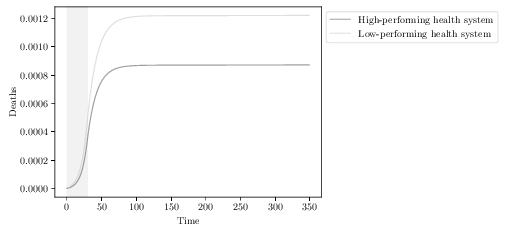

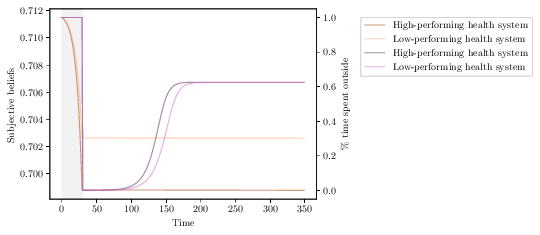

In [17]:
##Health care system performance

def toplot(values):
    x=[]
    for value in range(len(values)):
        x.append(np.array(values[value]))
    return x


#Pt#
pmhs1, pmhs2= toplot([BMM(30,1,1,1.1,1,0.5,1)[8],
                                       BMM(30,1,1,1,1,1,1)[8]])
#Kt#
kmhs1, kmhs2= toplot([BMM(30,1,1,1.1,1,0.5,1)[9],
                                      BMM(30,1,1,1,1,1,1)[9]])


#Deaths#
dhs0=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[0]))
dhs1=np.cumsum(np.array(BMM(30,1,1,1.1,1,0.5,1)[1]))
dhs2=np.cumsum(np.array(BMM(30,1,1,1,1,1,1)[1]))


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(dhs1, grey2,alpha=0.5, lw=1, label='High-performing health system')
ax.plot(dhs2, grey6,alpha=0.5, lw=1, label='Low-performing health system')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_PolicyGv_Deaths.pdf',bbox_inches='tight')


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM002=ax.plot(pmhs1, ora2,alpha=0.5, lw=1, label='High-performing health system')
PM003=ax.plot(pmhs2, ora6,alpha=0.5, lw=1, label='Low-performing health system')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs ')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K002=ax2.plot(kmhs1, pur2,alpha=0.5, lw=1, label='High-performing health system')
K003=ax2.plot(kmhs2, pur6,alpha=0.5, lw=1, label='Low-performing health system')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM002+PM003+K002+K003
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=1,bbox_to_anchor=(1.83, 0.8))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_PolicyGv_PK.pdf',bbox_inches='tight')


## Sensitivity analysis

#### Diamond Princess
The data used for this scenario comes from Mizumoto et al. (2020) and Zhang et al. (2020),
$\mu 0.179= $, $\gamma 1/7.5 = $ and $R_0= 2.28 $.

#### Acemoglu
The data used for this scenario comes from Acemoglu et al. (2020), 
$\mu = 0.4$, $\gamma = 1/18$ and $R_0= 2.4$.


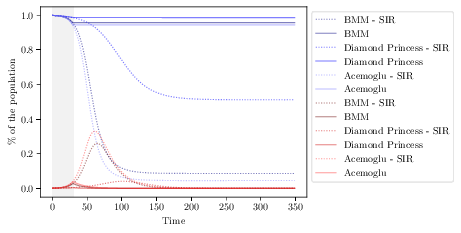

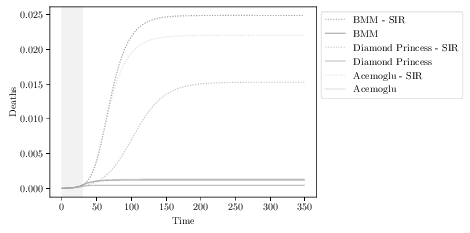

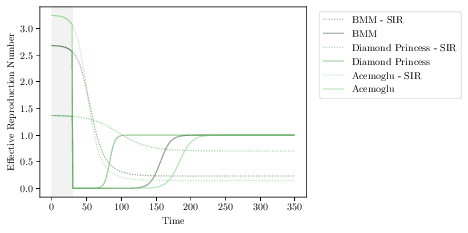

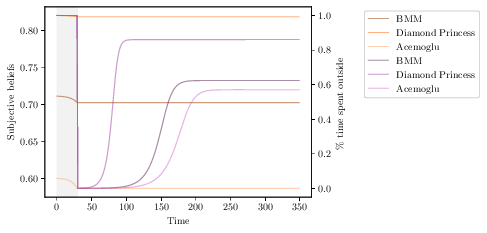

In [18]:
## Sensitivity Analysis

##DIAMOND PRINCESS
#Susceptible#
SdpSIR = BMM(30,1,1,2,0.8261,1,0.6205)[2]
Sdp = BMM(30,1,1,2,0.8261,1,0.6205)[5]
#Infected#
IdpSIR = BMM(30,1,1,2,0.8261,1,0.6205)[3]
Idp = BMM(30,1,1,2,0.8261,1,0.6205)[6]
#Pt#
Pdp = BMM(30,1,1,2,0.8261,1,0.6205)[8]
#Kt#
Kdp = BMM(30,1,1,2,0.8261,1,0.6205)[9]
#ERN#
ERNdpSIR = BMM(30,1,1,2,0.8261,1,0.6205)[10]
ERNdp = BMM(30,1,1,2,0.8261,1,0.6205)[11]
#Deaths#
DdpSIR = np.cumsum(np.array(BMM(30,1,1,2,0.8261,1,0.6205)[0]))
Ddp = np.cumsum(np.array(BMM(30,1,1,2,0.8261,1,0.6205)[1]))

##ACEMOGLU
#Susceptible#
SaSIR = BMM(30,1,1,(15/18),0.8696,1,1.3865)[2]
Sa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[5]
#Infected#
IaSIR = BMM(30,1,1,(15/18),0.8696,1,1.3865)[3]
Ia = BMM(30,1,1,(15/18),0.8696,1,1.3865)[6]
#Pt#
Pa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[8]
#Kt#
Ka = BMM(30,1,1,(15/18),0.8696,1,1.3865)[9]
#ERN#
ERNaSIR = BMM(30,1,1,(15/18),0.8696,1,1.3865)[10]
ERNa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[11]
#Deaths#
DaSIR = np.cumsum(np.array(BMM(30,1,1,(15/18),0.8696,1,1.3865)[0]))
Da = np.cumsum(np.array(BMM(30,1,1,(15/18),0.8696,1,1.3865)[1]))

## Sensitivity analysis - s, i 
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(sm00, blu2,linestyle=':',alpha=0.5, lw=1, label='BMM - SIR')
ax.plot(sm30, blu2,alpha=0.5, lw=1, label='BMM')
ax.plot(SdpSIR, blu4,linestyle=':',alpha=0.5, lw=1, label='Diamond Princess - SIR')
ax.plot(Sdp, blu4,alpha=0.5, lw=1, label='Diamond Princess')
ax.plot(SaSIR, blu6,linestyle=':',alpha=0.5, lw=1, label='Acemoglu - SIR')
ax.plot(Sa, blu6,alpha=0.5, lw=1, label='Acemoglu')
ax.plot(im00, red2,linestyle=':', alpha=0.5, lw=1, label='BMM - SIR')
ax.plot(im30, red2,alpha=0.5, lw=1, label='BMM')
ax.plot(IdpSIR, red4,linestyle=':', alpha=0.5, lw=1, label='Diamond Princess - SIR')
ax.plot(Idp, red4,alpha=0.5, lw=1, label='Diamond Princess')
ax.plot(IaSIR, red6,linestyle=':', alpha=0.5, lw=1, label='Acemoglu - SIR')
ax.plot(Ia, red6,alpha=0.5, lw=1, label='Acemoglu')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('$\%$ of the population')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_Dyn.pdf',bbox_inches='tight')

## Sensitivity analysis - deaths 
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(d00, grey2,linestyle=':', alpha=0.5, lw=1, label='BMM - SIR')
ax.plot(d30, grey2,alpha=0.5, lw=1, label='BMM')
ax.plot(DdpSIR, grey4,linestyle=':', alpha=0.5, lw=1, label='Diamond Princess - SIR')
ax.plot(Ddp, grey4,alpha=0.5, lw=1, label='Diamond Princess')
ax.plot(DaSIR, grey6,linestyle=':', alpha=0.5, lw=1, label='Acemoglu - SIR')
ax.plot(Da, grey6,alpha=0.5, lw=1, label='Acemoglu')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_Deaths.pdf',bbox_inches='tight')

## Sensitivity analysis - ern
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ern00, gre2,linestyle=':',alpha=0.5, lw=1, label='BMM - SIR')
ax.plot(ern30, gre2,alpha=0.5, lw=1, label='BMM')
ax.plot(ERNdpSIR, gre4,linestyle=':',alpha=0.5, lw=1, label='Diamond Princess - SIR')
ax.plot(ERNdp, gre4,alpha=0.5, lw=1, label='Diamond Princess')
ax.plot(ERNaSIR, gre6,linestyle=':',alpha=0.5, lw=1, label='Acemoglu - SIR')
ax.plot(ERNa, gre6,alpha=0.5, lw=1, label='Acemoglu')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.60, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_ERN.pdf',bbox_inches='tight')

## Sensitivity analysis - pt, kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM001=ax.plot(pm30, ora2,alpha=0.5, lw=1, label='BMM')
PM002=ax.plot(Pdp, ora4,alpha=0.5, lw=1, label='Diamond Princess')
PM003=ax.plot(Pa, ora6,alpha=0.5, lw=1, label='Acemoglu')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K001=ax2.plot(km30, pur2,alpha=0.5, lw=1, label='BMM')
K002=ax2.plot(Kdp, pur4,alpha=0.5, lw=1, label='Diamond Princess')
K003=ax2.plot(Ka, pur6,alpha=0.5, lw=1, label='Acemoglu')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax2.set_ylabel('$\%$ time spent outside ')
COMB=PM001+PM002+PM003+K001+K002+K003
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=1,bbox_to_anchor=(1.65, 0.75))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_PK.pdf',bbox_inches='tight')



### Simulation on $\beta \mu$

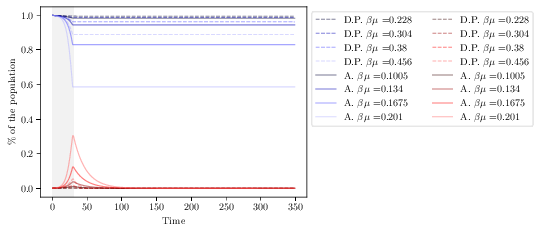

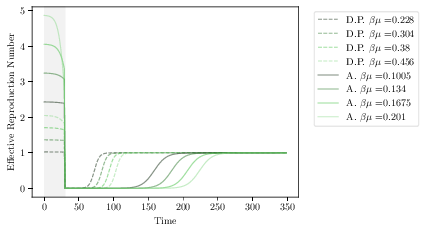

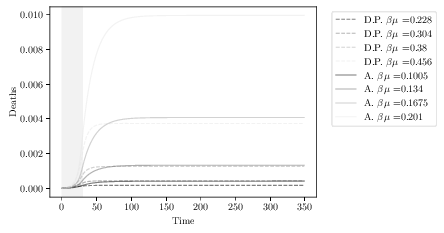

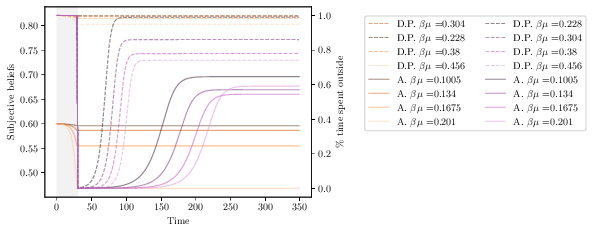

In [19]:
## Sensitivity Analysis - \beta \mu


##DIAMOND PRINCESS
#Susceptible#
Sdp = BMM(30,1,1,2,0.8261,1,0.6205)[5]
Sdpb08 = BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[5]
Sdpb12 = BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[5]
Sdpb15 = BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[5]
Sdpg08 = BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[5]
Sdpg12 = BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[5]
Sdpg15 = BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[5]
#Infected#
Idp = BMM(30,1,1,2,0.8261,1,0.6205)[6]
Idpb08 = BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[6]
Idpb12 = BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[6]
Idpb15 = BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[6]
Idpg08 = BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[6]
Idpg12 = BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[6]
Idpg15 = BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[6]
#Pt#
Pdp = BMM(30,1,1,2,0.8261,1,0.6205)[8]
Pdpb08 = BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[8]
Pdpb12 = BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[8]
Pdpb15 = BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[8]
Pdpg08 = BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[8]
Pdpg12 = BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[8]
Pdpg15 = BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[8]
#Kt#
Kdp = BMM(30,1,1,2,0.8261,1,0.6205)[9]
Kdpb08 = BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[9]
Kdpb12 = BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[9]
Kdpb15 = BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[9]
Kdpg08 = BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[9]
Kdpg12 = BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[9]
Kdpg15 = BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[9]
#ERN#
ERNdp = BMM(30,1,1,2,0.8261,1,0.6205)[11]
ERNdpb08 = BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[11]
ERNdpb12 = BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[11]
ERNdpb15 = BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[11]
ERNdpg08 = BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[11]
ERNdpg12 = BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[11]
ERNdpg15 = BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[11]
#Deaths#
Ddpb08 = np.cumsum(np.array(BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[1]))
Ddpb12 = np.cumsum(np.array(BMM(30,1,1,2,(0.8261*1.25),1,0.6205)[1]))
Ddpb15 = np.cumsum(np.array(BMM(30,1,1,2,(0.8261*1.5),1,0.6205)[1]))
Ddpg08 = np.cumsum(np.array(BMM(30,1,1,(2*0.75),0.8261,1,0.6205)[1]))
Ddpg12 = np.cumsum(np.array(BMM(30,1,1,(2*1.25),0.8261,1,0.6205)[1]))
Ddpg15 = np.cumsum(np.array(BMM(30,1,1,(2*1.5),0.8261,1,0.6205)[1]))

##ACEMOGLU
#Susceptible#
Sa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[5]
Sab08 = BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[5]
Sab12 = BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[5]
Sab15 = BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[5]
Sag08 = BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[5]
Sag12 = BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[5]
Sag15 = BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[5]
#Infected#
Ia = BMM(30,1,1,(15/18),0.8696,1,1.3865)[6]
Iab08 = BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[6]
Iab12 = BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[6]
Iab15 = BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[6]
Iag08 = BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[6]
Iag12 = BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[6]
Iag15 = BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[6]
#Pt#
Pa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[8]
Pab08 = BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[8]
Pab12 = BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[8]
Pab15 = BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[8]
Pag08 = BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[8]
Pag12 = BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[8]
Pag15 = BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[8]
#Kt#
Ka = BMM(30,1,1,(15/18),0.8696,1,1.3865)[9]
Kab08 = BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[9]
Kab12 = BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[9]
Kab15 = BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[9]
Kag08 = BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[9]
Kag12 = BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[9]
Kag15 = BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[9]
#ERN#
ERNa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[11]
ERNab08 = BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[11]
ERNab12 = BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[11]
ERNab15 = BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[11]
ERNag08 = BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[11]
ERNag12 = BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[11]
ERNag15 = BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[11]
#Deaths#
Dab08 = np.cumsum(np.array(BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[1]))
Dab12 = np.cumsum(np.array(BMM(30,1,1,(15/18),(0.8696*1.25),1,1.3865)[1]))
Dab15 = np.cumsum(np.array(BMM(30,1,1,(15/18),(0.8696*1.5),1,1.3865)[1]))
Dag08 = np.cumsum(np.array(BMM(30,1,1,((15/18)*0.75),0.8696,1,1.3865)[1]))
Dag12 = np.cumsum(np.array(BMM(30,1,1,((15/18)*1.25),0.8696,1,1.3865)[1]))
Dag15 = np.cumsum(np.array(BMM(30,1,1,((15/18)*1.5),0.8696,1,1.3865)[1]))

#BETAMU
## Sensitivity analysis - betamu - s, i
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Sdpb08, blu1, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
ax.plot(Sdp, blu3,linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
ax.plot(Sdpb12, blu5, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
ax.plot(Sdpb15, blu7, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
ax.plot(Sab08, blu1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
ax.plot(Sa, blu3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
ax.plot(Sab12, blu5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
ax.plot(Sab15, blu7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax.plot(Idpb08, red1, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
ax.plot(Idp, red3, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
ax.plot(Idpb12, red5, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
ax.plot(Idpb15, red7, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
ax.plot(Iab08, red1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
ax.plot(Ia, red3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
ax.plot(Iab12, red5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
ax.plot(Iab15, red7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('\% of the population')
legend = ax.legend(loc='best', ncol=2,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DynB.pdf',bbox_inches='tight')

## Sensitivity analysis - betamu - ern
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ERNdpb08, gre1, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
ax.plot(ERNdp, gre3, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
ax.plot(ERNdpb12, gre5, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
ax.plot(ERNdpb15, gre7, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
ax.plot(ERNab08, gre1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
ax.plot(ERNa, gre3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
ax.plot(ERNab12, gre5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
ax.plot(ERNab15, gre7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.47, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_ERNB.pdf',bbox_inches='tight')

## Sensitivity analysis - betamu - deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Ddpb08, grey1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
ax.plot(Ddp, grey3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
ax.plot(Ddpb12, grey5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
ax.plot(Ddpb15, grey7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
ax.plot(Dab08, grey1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
ax.plot(Da, grey3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
ax.plot(Dab12, grey5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
ax.plot(Dab15, grey7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.47, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DeathsB.pdf',bbox_inches='tight')

## Sensitivity analysis - betamu - pt, kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM001=ax.plot(Pdpb08, ora1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
PM002=ax.plot(Pdp, ora3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
PM003=ax.plot(Pdpb12, ora5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
PM004=ax.plot(Pdpb15, ora7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
PM005=ax.plot(Pab08, ora1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
PM006=ax.plot(Pa, ora3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
PM007=ax.plot(Pab12, ora5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
PM008=ax.plot(Pab15, ora7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K001=ax2.plot(Kdpb08, pur1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.228')
K002=ax2.plot(Kdp, pur3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.304')
K003=ax2.plot(Kdpb12, pur5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.38')
K004=ax2.plot(Kdpb15, pur7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\beta \mu$ =0.456')
K005=ax2.plot(Kab08, pur1,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1005')
K006=ax2.plot(Ka, pur3,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.134')
K007=ax2.plot(Kab12, pur5,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.1675')
K008=ax2.plot(Kab15, pur7,alpha=0.5, lw=1, label='A. ' r'$\beta \mu$ =0.201')
ax2.set_ylabel('$\%$ time spent outside')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
COMB=PM002+PM001+PM003+PM004+PM005+PM006+PM007+PM008+K001+K002+K003+K004+K005+K006+K007+K008
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(2.05, 0.65))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_PKB.pdf',bbox_inches='tight')


### Health care system performance

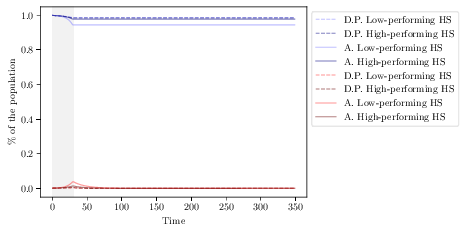

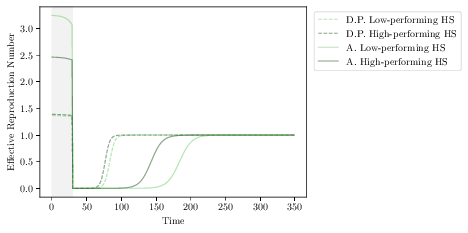

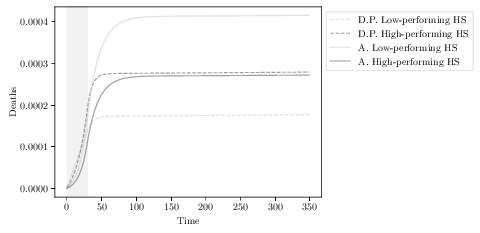

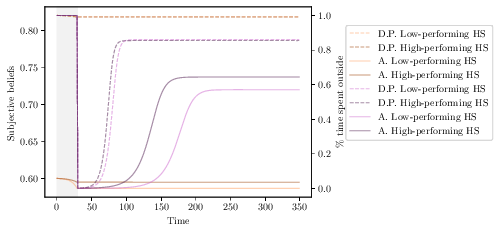

In [20]:
##Health care system performance

##DIAMOND PRINCESS
#Susceptible#
Sdp = BMM(30,1,1,2,0.8261,1,0.6205)[5]
SdphsH = BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[5]
#Infected#
Idp = BMM(30,1,1,2,0.8261,1,0.6205)[6]
IdphsH = BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[6]
#Pt#
Pdp = BMM(30,1,1,2,0.8261,1,0.6205)[8]
PdphsH = BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[8]
#Kt#
Kdp = BMM(30,1,1,2,0.8261,1,0.6205)[9]
KdphsH = BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[9]
#ERN#
ERNdp = BMM(30,1,1,2,0.8261,1,0.6205)[11]
ERNdphsH = BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[11]
#Deaths#
Ddp = np.cumsum(np.array(BMM(30,1,1,2,(0.8261*0.75),1,0.6205)[1]))
DdphsH = np.cumsum(np.array(BMM(30,1,1,2*1.1,(0.8261),1*0.5,0.6205)[1]))

##ACEMOGLU
#Susceptible#
Sa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[5]
SahsH = BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[5]
#Infected#
Ia = BMM(30,1,1,(15/18),0.8696,1,1.3865)[6]
IahsH = BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[6]
#Pt#
Pa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[8]
PahsH = BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[8]
#Kt#
Ka = BMM(30,1,1,(15/18),0.8696,1,1.3865)[9]
KahsH = BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[9]
#ERN#
ERNa = BMM(30,1,1,(15/18),0.8696,1,1.3865)[11]
ERNahsH = BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[11]
#Deaths#
Da = np.cumsum(np.array(BMM(30,1,1,(15/18),(0.8696*0.75),1,1.3865)[1]))
DahsH = np.cumsum(np.array(BMM(30,1,1,(15/18)*1.1,(0.8696*0.75),1*0.5,1.3865)[1]))

## Sensitivity analysis - hcsp - s, i
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Sdp, blu6,linestyle='dashed', alpha=0.5, lw=1, label='D.P. Low-performing HS')
ax.plot(SdphsH, blu2, linestyle='dashed',alpha=0.5, lw=1, label='D.P. High-performing HS')
ax.plot(Sa, blu6,alpha=0.5, lw=1, label='A. Low-performing HS')
ax.plot(SahsH, blu2,alpha=0.5, lw=1, label='A. High-performing HS')
ax.plot(Idp, red6, linestyle='dashed',alpha=0.5, lw=1, label='D.P. Low-performing HS')
ax.plot(IdphsH, red2, linestyle='dashed', alpha=0.5, lw=1, label='D.P. High-performing HS')
ax.plot(Ia, red6,alpha=0.5, lw=1, label='A. Low-performing HS')
ax.plot(IahsH, red2,alpha=0.5, lw=1, label='A. High-performing HS')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('\% of the population')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DynHS.pdf',bbox_inches='tight')

## Sensitivity analysis - hcsp - ern
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ERNdp, gre6, linestyle='dashed',alpha=0.5, lw=1, label='D.P. Low-performing HS')
ax.plot(ERNdphsH, gre2, linestyle='dashed',alpha=0.5, lw=1, label='D.P. High-performing HS')
ax.plot(ERNa, gre6,alpha=0.5, lw=1, label='A. Low-performing HS')
ax.plot(ERNahsH, gre2,alpha=0.5, lw=1, label='A. High-performing HS')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.6, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_ERNHS.pdf',bbox_inches='tight')

## Sensitivity analysis - hcsp - deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Ddp, grey6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. Low-performing HS')
ax.plot(DdphsH, grey2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. High-performing HS')
ax.plot(Da, grey6,alpha=0.5, lw=1, label='A. Low-performing HS')
ax.plot(DahsH, grey2,alpha=0.5, lw=1, label='A. High-performing HS')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DeathsHS.pdf',bbox_inches='tight')

## Sensitivity analysis - hcsp - pt, kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM002=ax.plot(Pdp, ora6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. Low-performing HS')
PM003=ax.plot(PdphsH, ora2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. High-performing HS')
PM006=ax.plot(Pa, ora6,alpha=0.5, lw=1, label='A. Low-performing HS')
PM007=ax.plot(PahsH, ora2,alpha=0.5, lw=1, label='A. High-performing HS')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs ')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K002=ax2.plot(Kdp, pur6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. Low-performing HS')
K003=ax2.plot(KdphsH, pur2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. High-performing HS')
K006=ax2.plot(Ka, pur6,alpha=0.5, lw=1, label='A. Low-performing HS')
K007=ax2.plot(KahsH, pur2,alpha=0.5, lw=1, label='A. High-performing HS')
ax2.set_ylabel('$\%$ time spent outside')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
COMB=PM002+PM003+PM006+PM007+K002+K003+K006+K007
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=1,bbox_to_anchor=(1.7, 0.6))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_PKHS.pdf',bbox_inches='tight')

### Simulation on $\gamma$

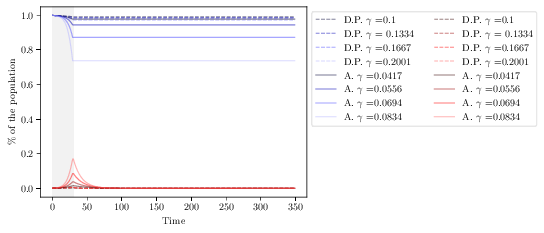

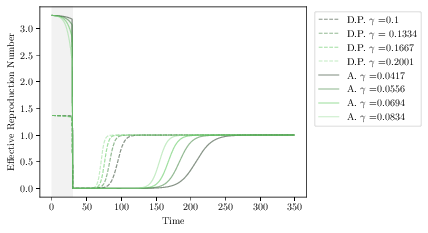

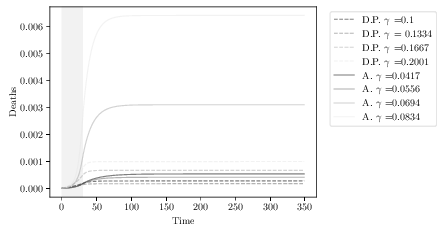

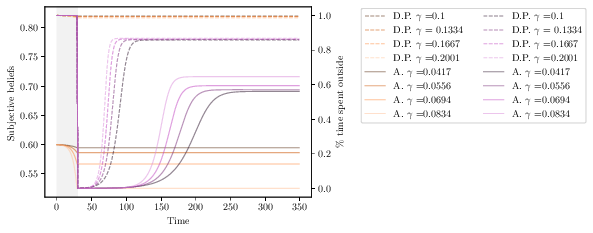

In [21]:
## Sensitivity analysis - gamma


## Sensitivity analysis - gamma - s, i
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Sdpg08, blu1, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
ax.plot(Sdp, blu3,linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
ax.plot(Sdpg12, blu5, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
ax.plot(Sdpg15, blu7, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
ax.plot(Sag08, blu1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
ax.plot(Sa, blu3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
ax.plot(Sag12, blu5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
ax.plot(Sag15, blu7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax.plot(Idpg08, red1, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
ax.plot(Idp, red3, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
ax.plot(Idpg12, red5, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
ax.plot(Idpg15, red7, linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
ax.plot(Iag08, red1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
ax.plot(Ia, red3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
ax.plot(Iag12, red5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
ax.plot(Iag15, red7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
ax.set_xlabel('Time')
ax.set_ylabel('\% of the population')
legend = ax.legend(loc='best', ncol=2,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DynG.pdf',bbox_inches='tight')


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ERNdpg08, gre1, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
ax.plot(ERNdp, gre3, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
ax.plot(ERNdpg12, gre5, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
ax.plot(ERNdpg15, gre7, linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
ax.plot(ERNag08, gre1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
ax.plot(ERNa, gre3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
ax.plot(ERNag12, gre5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
ax.plot(ERNag15, gre7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.45, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_ERNG.pdf',bbox_inches='tight')

## Sensitivity analysis - gamma - deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Ddpg08, grey1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
ax.plot(Ddp, grey3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
ax.plot(Ddpg12, grey5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
ax.plot(Ddpg15, grey7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
ax.plot(Dag08, grey1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
ax.plot(Da, grey3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
ax.plot(Dag12, grey5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
ax.plot(Dag15, grey7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.47, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DeathsG.pdf',bbox_inches='tight')

## Sensitivity analysis - gamma - pt, kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM001=ax.plot(Pdpg08, ora1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
PM002=ax.plot(Pdp, ora3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
PM003=ax.plot(Pdpg12, ora5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
PM004=ax.plot(Pdpg15, ora7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
PM005=ax.plot(Pag08, ora1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
PM006=ax.plot(Pa, ora3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
PM007=ax.plot(Pag12, ora5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
PM008=ax.plot(Pag15, ora7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs ')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K001=ax2.plot(Kdpg08, pur1,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1')
K002=ax2.plot(Kdp, pur3,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ = 0.1334')
K003=ax2.plot(Kdpg12, pur5,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.1667')
K004=ax2.plot(Kdpg15, pur7,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\gamma$ =0.2001')
K005=ax2.plot(Kag08, pur1,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0417')
K006=ax2.plot(Ka, pur3,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0556')
K007=ax2.plot(Kag12, pur5,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0694')
K008=ax2.plot(Kag15, pur7,alpha=0.5, lw=1, label='A. ' r'$\gamma$ =0.0834')
ax2.set_ylabel('$\%$ time spent outside')
ax.axvspan(0, 30, alpha=0.5, color=grey7)
COMB=PM001+PM002+PM003+PM004+PM005+PM006+PM007+PM008+K001+K002+K003+K004+K005+K006+K007+K008
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(2.05, 0.69))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_PKG.pdf',bbox_inches='tight')

### Time of Announcement 

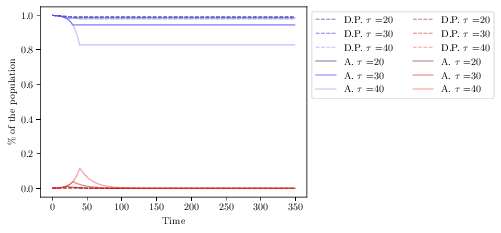

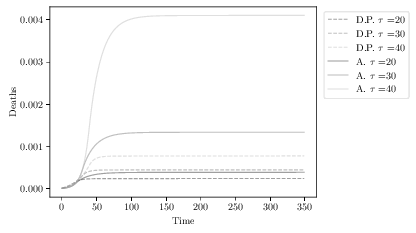

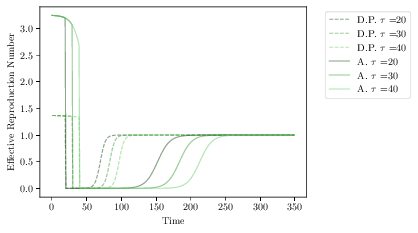

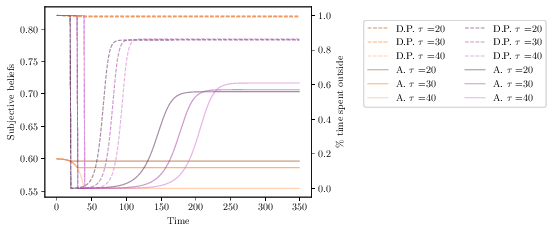

In [22]:
#Sensitivity analysis - time of announcement

##DIAMOND PRINCESS
#Susceptible#
Sdp20 = BMM(20,1,1,2,0.8261,1,0.6205)[5]
Sdp30 = BMM(30,1,1,2,0.8261,1,0.6205)[5]
Sdp40 = BMM(40,1,1,2,0.8261,1,0.6205)[5]

#Infected#
Idp20 = BMM(20,1,1,2,0.8261,1,0.6205)[6]
Idp30 = BMM(30,1,1,2,0.8261,1,0.6205)[6]
Idp40 = BMM(40,1,1,2,0.8261,1,0.6205)[6]
#Pt#
Pdp20 = BMM(20,1,1,2,0.8261,1,0.6205)[8]
Pdp30 = BMM(30,1,1,2,0.8261,1,0.6205)[8]
Pdp40 = BMM(40,1,1,2,0.8261,1,0.6205)[8]
#Kt#
Kdp20 = BMM(20,1,1,2,0.8261,1,0.6205)[9]
Kdp30 = BMM(30,1,1,2,0.8261,1,0.6205)[9]
Kdp40 = BMM(40,1,1,2,0.8261,1,0.6205)[9]
#ERN#
ERNdp20 = BMM(20,1,1,2,0.8261,1,0.6205)[11]
ERNdp30 = BMM(30,1,1,2,0.8261,1,0.6205)[11]
ERNdp40 = BMM(40,1,1,2,0.8261,1,0.6205)[11]
#Deaths#
Ddp20 = np.cumsum(np.array(BMM(20,1,1,2,0.8261,1,0.6205)[1]))
Ddp30 = np.cumsum(np.array(BMM(30,1,1,2,0.8261,1,0.6205)[1]))
Ddp40 = np.cumsum(np.array(BMM(40,1,1,2,0.8261,1,0.6205)[1]))

##ACEMOGLU
#Susceptible#
Sa20 = BMM(20,1,1,(15/18),0.8696,1,1.3865)[5]
Sa30 = BMM(30,1,1,(15/18),0.8696,1,1.3865)[5]
Sa40 = BMM(40,1,1,(15/18),0.8696,1,1.3865)[5]
#Infected#
Ia20 = BMM(20,1,1,(15/18),0.8696,1,1.3865)[6]
Ia30 = BMM(30,1,1,(15/18),0.8696,1,1.3865)[6]
Ia40 = BMM(40,1,1,(15/18),0.8696,1,1.3865)[6]
#Pt#
Pa20 = BMM(20,1,1,(15/18),0.8696,1,1.3865)[8]
Pa30 = BMM(30,1,1,(15/18),0.8696,1,1.3865)[8]
Pa40 = BMM(40,1,1,(15/18),0.8696,1,1.3865)[8]
#Kt#
Ka20 = BMM(20,1,1,(15/18),0.8696,1,1.3865)[9]
Ka30 = BMM(30,1,1,(15/18),0.8696,1,1.3865)[9]
Ka40 = BMM(40,1,1,(15/18),0.8696,1,1.3865)[9]
#ERN#
ERNa20 = BMM(20,1,1,(15/18),0.8696,1,1.3865)[11]
ERNa30 = BMM(30,1,1,(15/18),0.8696,1,1.3865)[11]
ERNa40 = BMM(40,1,1,(15/18),0.8696,1,1.3865)[11]
#Deaths#
Da20 = np.cumsum(np.array(BMM(20,1,1,(15/18),0.8696,1,1.3865)[1]))
Da30 = np.cumsum(np.array(BMM(30,1,1,(15/18),0.8696,1,1.3865)[1]))
Da40 = np.cumsum(np.array(BMM(40,1,1,(15/18),0.8696,1,1.3865)[1]))

## Sensitivity analysis - time of announcement - s, i
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Sdp20, blu2,linestyle='dashed', alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
ax.plot(Sdp30, blu4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
ax.plot(Sdp40, blu6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
ax.plot(Sa20, blu2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
ax.plot(Sa30, blu4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
ax.plot(Sa40, blu6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax.plot(Idp20, red2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
ax.plot(Idp30, red4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
ax.plot(Idp40, red6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
ax.plot(Ia20, red2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
ax.plot(Ia30, red4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
ax.plot(Ia40, red6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('\% of the population')
legend = ax.legend(loc='best', ncol=2,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DynaAN.pdf',bbox_inches='tight')

## Sensitivity analysis - time of announcement - deaths
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(Ddp20, grey2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
ax.plot(Ddp30, grey4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
ax.plot(Ddp40, grey6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
ax.plot(Da20, grey2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
ax.plot(Da30, grey4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
ax.plot(Da40, grey6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.01, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_DeathsAN.pdf',bbox_inches='tight')

## Sensitivity analysis - time of announcement - ern
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ERNdp20, gre2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
ax.plot(ERNdp30, gre4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
ax.plot(ERNdp40, gre6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
ax.plot(ERNa20, gre2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
ax.plot(ERNa30, gre4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
ax.plot(ERNa40, gre6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1.41, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_ERNAN.pdf',bbox_inches='tight')

## Sensitivity analysis - time of announcement - pt, kt
fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM001=ax.plot(Pdp20, ora2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
PM002=ax.plot(Pdp30, ora4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
PM003=ax.plot(Pdp40, ora6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
PM004=ax.plot(Pa20, ora2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
PM005=ax.plot(Pa30, ora4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
PM006=ax.plot(Pa40, ora6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K001=ax2.plot(Kdp20, pur2,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =20')
K002=ax2.plot(Kdp30, pur4,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =30')
K003=ax2.plot(Kdp40, pur6,linestyle='dashed',alpha=0.5, lw=1, label='D.P. ' r'$\tau$ =40')
K004=ax2.plot(Ka20, pur2,alpha=0.5, lw=1, label='A. ' r'$\tau$ =20')
K005=ax2.plot(Ka30, pur4,alpha=0.5, lw=1, label='A. ' r'$\tau$ =30')
K006=ax2.plot(Ka40, pur6,alpha=0.5, lw=1, label='A. ' r'$\tau$ =40')
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM001+PM002+PM003+PM004+PM005+PM006+K001+K002+K003+K004+K005+K006
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(1.90, 0.70))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_AnSen_PKAN.pdf',bbox_inches='tight')
